# Multiple star systems

One of the signature capabilities of **isochrones** is the ability to fit multiple star systems to observational data.  This works by providing a `StarModel` with more detailed information about the observational data, and about how many stars you wish to fit.  There are several layers of potential intricacy here, which we will walk through in stages.

## Unresolved multiple systems

Often it is of interest to know what potential binary star configurations are consistent with observations of a star.  For most stars the best available observational data is a combination of broadband magnitudes from various all-sky catalogs and parallax measurements from *Gaia*.  Let's first generate synthetic observations of such a star, and then see what we can recover with a binary or triple star model, and also what inference of this system under a single star model would tell us.

Note here that for this simplest of multiple star scenarios---unresolved, physically associated, binary or triple-star systems---there are special `StarModel` objects available that have more highly optimized likelihood calculations, analogous to the `SingleStarModel` that is available for a simple single-star fit.  `BinaryStarModel` and `TripleStarModel` are these special objects.  In order to accommodate more complex scenarios, such as fitting resolved steller companions, it is necessary to use the vanilla `StarModel` object. 

First, we will initialize the isochrone interpolator.  Note that we actually *require* the isochrone interpolator here, rather than the evolution track interpolator, because the model requires the primary and secondary components to have the same age, so that age must be a sampling paramter.

In [1]:
from isochrones import get_ichrone

mist = get_ichrone('mist')

Now, define the "true" system parameters and initialize the `StarModel` accordingly, with two model stars.  Remember that even though we need to use an isochrone interpolator to fit the model, we have to use the evolution tracks to generate synthetic data; this here shows that you can actually do this by using the `.track` complementary attribute.  Note also the use of the utility function `addmags` to combine the magnitudes of the two stars.

In [2]:
from isochrones import BinaryStarModel
from isochrones.utils import addmags

distance = 500  # pc
AV = 0.2
mass_A = 1.0
mass_B = 0.5
age = 9.6
feh = 0.0

# Synthetic 2MASS and Gaia magnitudes
bands = ['J', 'H', 'K', 'BP', 'RP', 'G']
props_A = mist.track.generate(mass_A, age, feh, distance=distance, AV=AV, 
                              bands=bands, return_dict=True, accurate=True)
props_B = mist.track.generate(mass_B, age, feh, distance=distance, AV=AV, 
                              bands=bands, return_dict=True, accurate=True)

unc = dict(J=0.02, H=0.02, K=0.02, BP=0.002, RP=0.002, G=0.001)
mags_tot = {b: (addmags(props_A[b], props_B[b]), unc[b]) for b in bands}

# Gaia parallax in mas for a system at 500 pc
parallax = (2, 0.05)

mod_binary = BinaryStarModel(mist, **mags_tot, parallax=parallax, name='demo_binary')

This model has the following parameters; `eep_0` and `eep_1` correspond to the primary and secondary components, respectively.  All the other parameters are assumed to be the same between the two components; that is, they are assumed to be co-eval and co-located.

In [3]:
mod_binary.param_names

('eep_0', 'eep_1', 'age', 'feh', 'distance', 'AV')

Let's also restrict the prior ranges for the parameters, to help with convergence.

In [4]:
mod_binary.set_bounds(eep=(1, 600), age=(8, 10))

Let's test out the posterior computation, and then run a fit to see if we can recover the true parameters.

In [5]:
pars = [350., 300., 9.7, 0.0, 300., 0.1]
print(mod_binary.lnpost(pars))
%timeit mod_binary.lnpost(pars)

-645802.2025506602
1000 loops, best of 3: 719 µs per loop


For a binary fit, it is often desirable to run with more than the default number of live points; here we double from 1000 to 2000.

In [6]:
mod_binary.fit(n_live_points=2000)  # takes about 14 minutes on my laptop

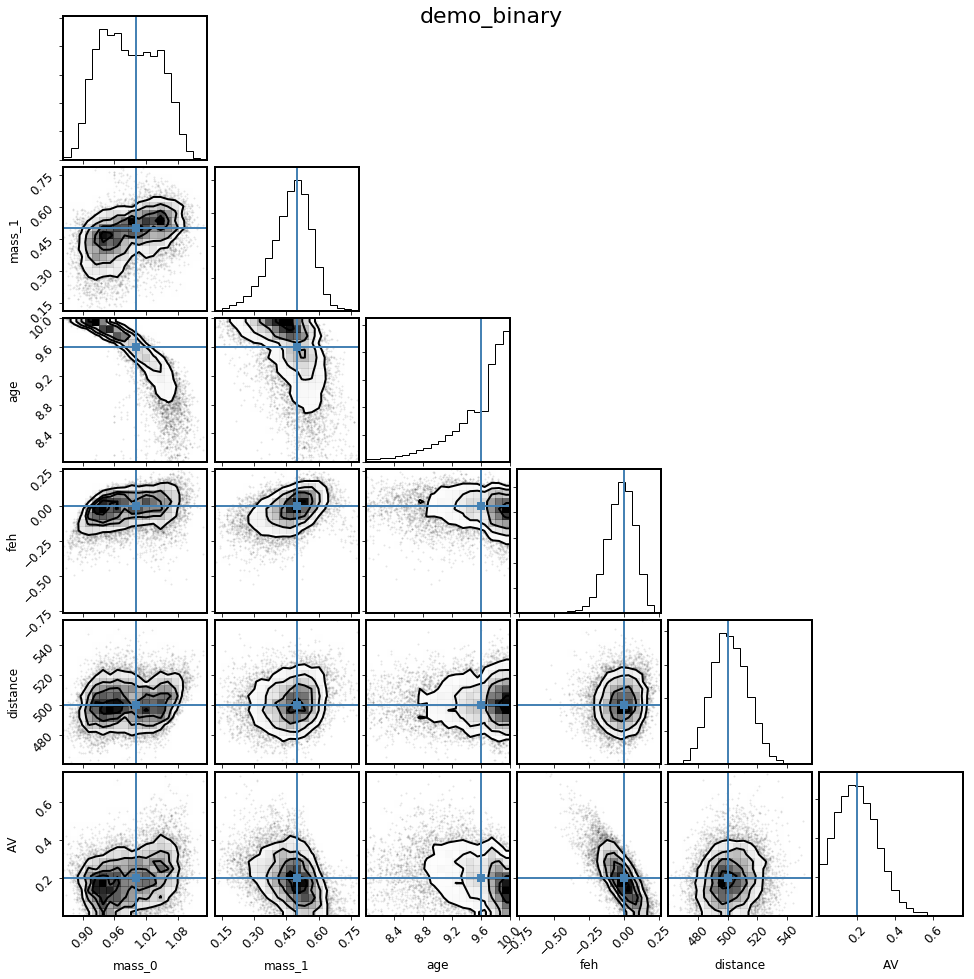

In [7]:
%matplotlib inline

columns = ['mass_0', 'mass_1', 'age', 'feh', 'distance', 'AV']
truths = [mass_A, mass_B, age, feh, distance, AV]
mod_binary.corner_derived(columns, truths=truths);

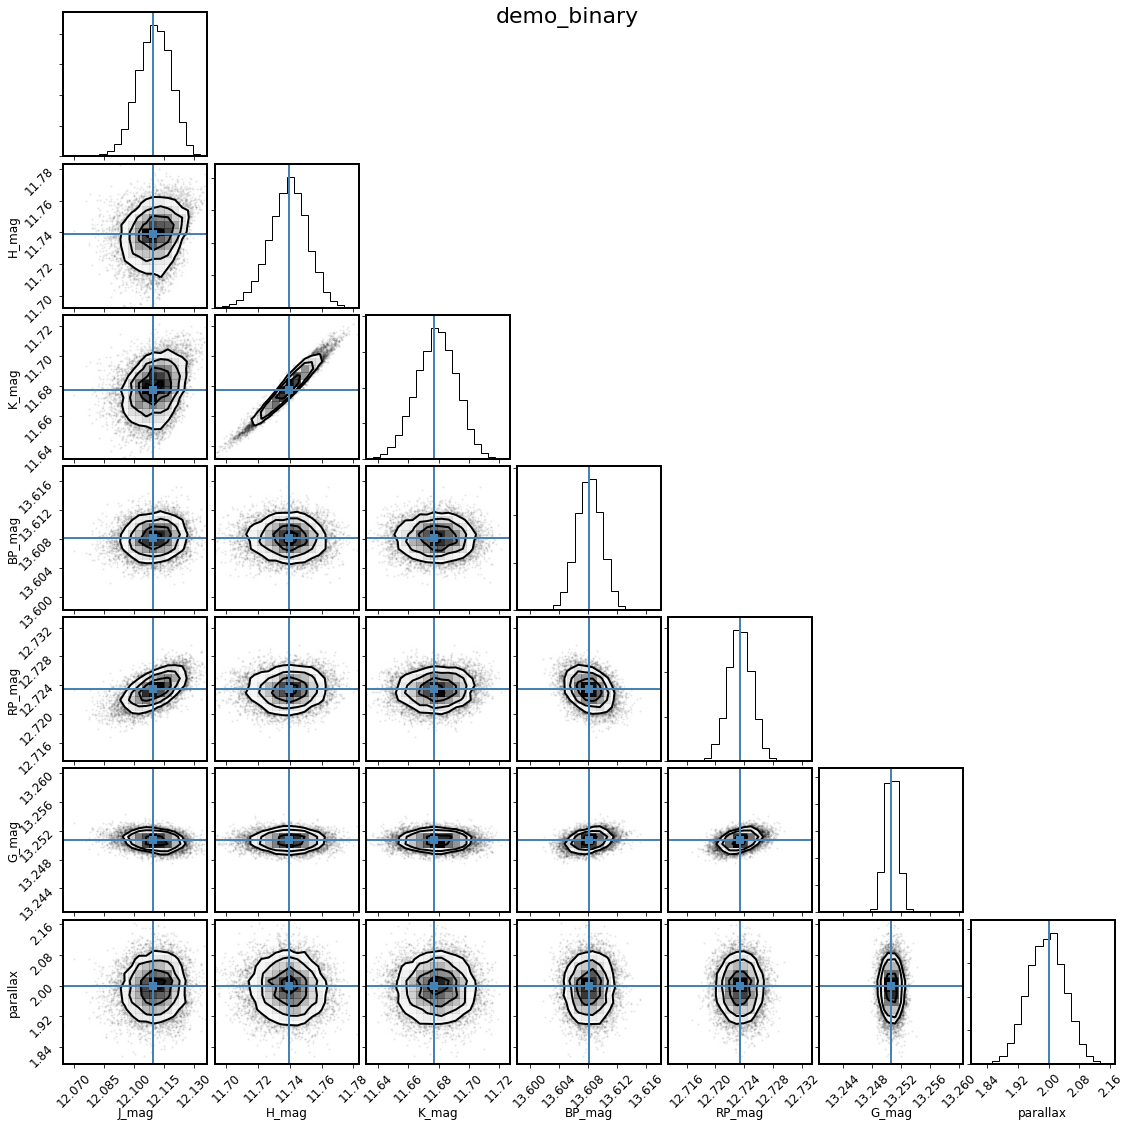

In [8]:
mod_binary.corner_observed();

Looks like this recovers the injected parameters pretty well, though not exactly.  It looks like the flat-linear age prior (which weights the fit significantly to older ages) is biasing the masses somewhat low.  Let's explore what happens if we change the prior and try again, imagining we have some other indicaton the log(age) should be around 9.6.

In [9]:
from isochrones.priors import GaussianPrior

mod_binary_2 = BinaryStarModel(mist, **mags_tot, parallax=parallax, name='demo_binary_2')
mod_binary_2.set_bounds(eep=(1, 600))
mod_binary_2.set_prior(age=GaussianPrior(9.6, 1, bounds=(8,10)))
mod_binary_2.lnpost(pars)


-645802.7700077017

In [10]:
mod_binary_2.fit(n_live_points=2000)

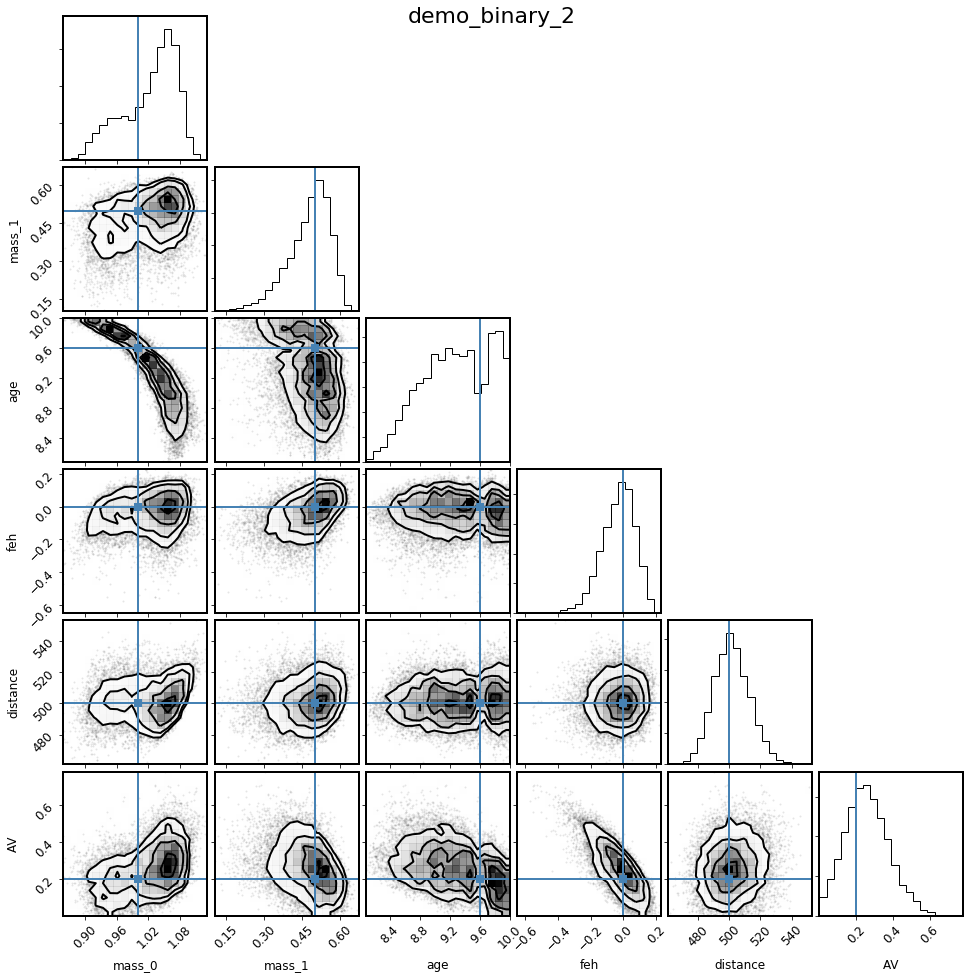

In [11]:
mod_binary_2.corner_derived(columns, truths=truths);

Hmm, doesn't seem to be much different.  Looks like this needs more exploration!

## Resolved multiple system

Another useful capability of **isochrones** is the ability to fit binary (or higher-order multiple) systems that are resolved in high-resolution imaging but blended in catalog photometry.  This is done by using the `StarModel` object directly (instead of the optimized models) and explicitly passing the observations.

As before, let's begin by using simulating data.  Let's pretend that the same binary system from above is resolved in AO $K$-band imaging, but blended in *2MASS* catalog data.  Let's say this time that we also have spectroscopic constraints of the primary properties.

Inspecting this tree to make sure it accurately represents the desired model becomes more important if the model is more complicated, but this simple case is a good example to review.  Each node named with a bandpass represents an observation, with some magnitude and uncertainty (at some separatrion and position angle---irrelevant for the unresolved case).  The model nodes here are named `0_0` and `0_1`, with the first index representing the system, and the second index the star number within that system.  All stars in the same system share the same age, metallicity, distance, and extinction.  In the computation of the likelihood, the apparent magnitude in each observed node is compared with a model-based magnitude that is computed from the *sum of the fluxes of all model nodes underneath that observed node in the tree*.  In the unresolved case, this is trivial, but this structure becomes important when a binary is resolved.  This model, because the two model stars share all attributes except mass, has the following parameters:

In [12]:
from isochrones import StarModel
from isochrones.observation import ObservationTree, Observation, Source

def build_obstree(name):
    obs = ObservationTree(name=name)
    for band in 'JHK':
        o = Observation('2MASS', band, 4)  # Name, band, resolution (in arcsec)
        s = Source(addmags(props_A[band], props_B[band]), 0.02)
        o.add_source(s)
        obs.add_observation(o)

    o = Observation('AO', 'K', 0.1)
    s_A = Source(0., 0.02, separation=0, pa=0, 
                 relative=True, is_reference=True)
    s_B = Source(props_B['K'] - props_A['K'], 0.02, separation=0.2, pa=100,
                 relative=True, is_reference=False)
    o.add_source(s_A)
    o.add_source(s_B)

    obs.add_observation(o)
    return obs

obs = build_obstree('demo_resolved')
mod_resolved = StarModel(mist, obs=obs, 
                         parallax=parallax, Teff=(props_A['Teff'], 100),
                         logg=(props_A['logg'], 0.15), feh=(props_A['feh'], 0.1))
mod_resolved.print_ascii()

demo_resolved
 ╚═ 2MASS J=(12.11, 0.02) @(0.00, 0 [4.00])
    ╚═ 2MASS H=(11.74, 0.02) @(0.00, 0 [4.00])
       ╚═ 2MASS K=(11.68, 0.02) @(0.00, 0 [4.00])
          ╠═ AO delta-K=(0.00, 0.02) @(0.00, 0 [0.10])
          ║  ╚═ 0_0, Teff=(5834.782979719397, 100), logg=(4.435999146983706, 0.15), feh=(-0.012519050601435218, 0.1), parallax=(2, 0.05)
          ╚═ AO delta-K=(2.43, 0.02) @(0.20, 100 [0.10])
             ╚═ 0_1, parallax=(2, 0.05)


In [13]:
pars = [300, 280, 9.6, 0.0, 400, 0.1]
mod_resolved.lnpost(pars)

-8443.175970078633

In [14]:
%timeit mod_resolved.lnpost(pars)

100 loops, best of 3: 1.23 ms per loop


In [15]:
mod_resolved.fit()

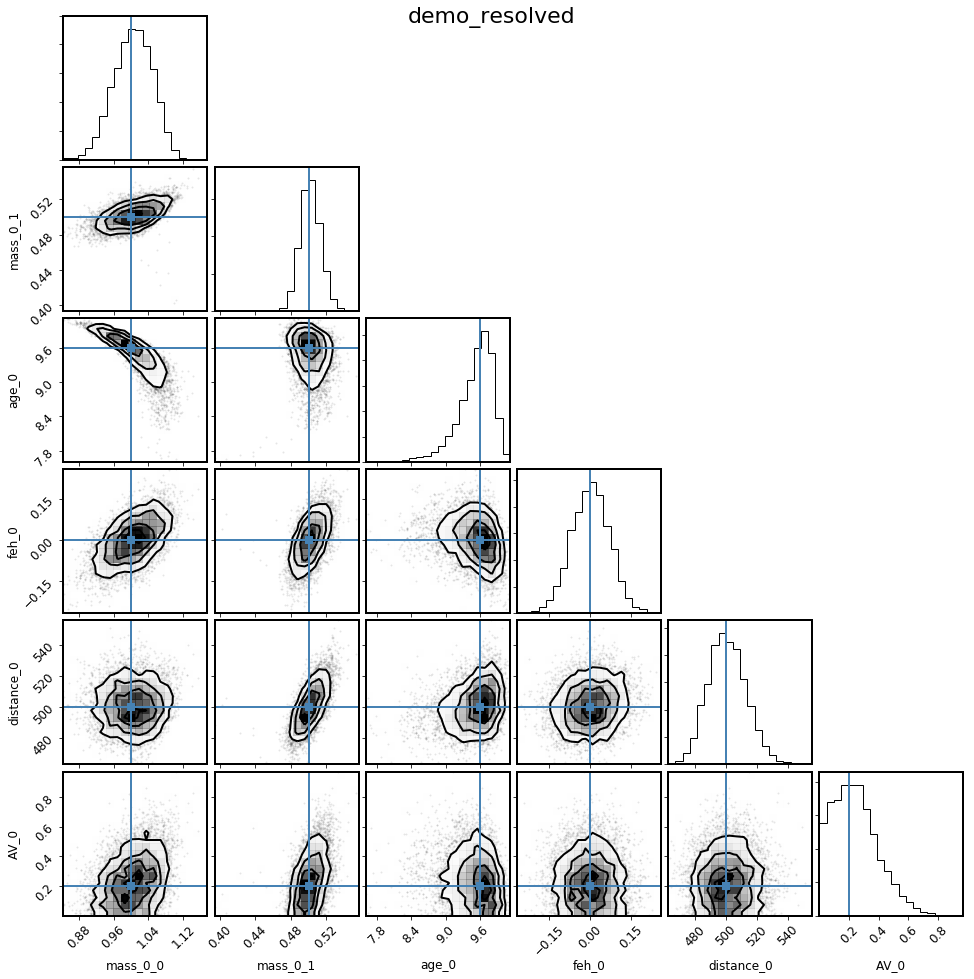

In [16]:
%matplotlib inline 

columns = ['mass_0_0', 'mass_0_1', 'age_0', 'feh_0', 'distance_0', 'AV_0']
truths = [mass_A, mass_B, age, feh, distance, AV]
mod_resolved.corner(columns, truths=truths);

Nailed it!  Looks like the spectroscopy was very helpful in getting the fit correct (age in particular).

## Unassociated companions

The previous two examples model a binary star system in which the two components are co-located and co-eval; that is, they have the same age, metallicity, distance, and extinction.  

One can imagine, however, wanting to model a scenario in which the two components are *not* physically associated, but rather just chance-aligned in the plane of the sky.  In this case, you can set up the `StarModel` with just a small difference:

In [17]:
obs = build_obstree('demo_resolved_unassoc')  # N.B., running this again, because the old "obs" was changed by the previous model
mod_resolved_unassoc = StarModel(mist, obs=obs, 
                         parallax=parallax, Teff=(props_A['Teff'], 100),
                         logg=(props_A['logg'], 0.15), feh=(props_A['feh'], 0.1),
                         index=[0, 1])
mod_resolved_unassoc.print_ascii()

demo_resolved_unassoc
 ╚═ 2MASS J=(12.11, 0.02) @(0.00, 0 [4.00])
    ╚═ 2MASS H=(11.74, 0.02) @(0.00, 0 [4.00])
       ╚═ 2MASS K=(11.68, 0.02) @(0.00, 0 [4.00])
          ╠═ AO delta-K=(0.00, 0.02) @(0.00, 0 [0.10])
          ║  ╚═ 0_0, Teff=(5834.782979719397, 100), logg=(4.435999146983706, 0.15), feh=(-0.012519050601435218, 0.1), parallax=(2, 0.05)
          ╚═ AO delta-K=(2.43, 0.02) @(0.20, 100 [0.10])
             ╚═ 1_0


Note that this model now has ten parameters, since the two systems are now decoupled, so we will not run the fit for this example, but it is in principle possible.  (Note that you would probably want to run this with MPI for this number of parameters.)

In [18]:
mod_resolved_unassoc.param_names

['eep_0_0',
 'age_0',
 'feh_0',
 'distance_0',
 'AV_0',
 'eep_1_0',
 'age_1',
 'feh_1',
 'distance_1',
 'AV_1']

## More complex models

You can define arbitrarily complex models, by explicitly defining the model nodes by hand, using the `N` and `index` keywords.  Below are some examples.

This is a physically associated hierarchical triple, where the bright star from AO is an unresolved binary:

In [19]:
obs = build_obstree('triple1')
StarModel(mist, obs=obs, N=[2, 1], index=[0, 0]).print_ascii()

triple1
 ╚═ 2MASS J=(12.11, 0.02) @(0.00, 0 [4.00])
    ╚═ 2MASS H=(11.74, 0.02) @(0.00, 0 [4.00])
       ╚═ 2MASS K=(11.68, 0.02) @(0.00, 0 [4.00])
          ╠═ AO delta-K=(0.00, 0.02) @(0.00, 0 [0.10])
          ║  ╠═ 0_0
          ║  ╚═ 0_1
          ╚═ AO delta-K=(2.43, 0.02) @(0.20, 100 [0.10])
             ╚═ 0_2


Here is a situation where the faint visual binary is an unrelated binary star:

In [20]:
obs = build_obstree('triple2')
StarModel(mist, obs=obs, N=[1, 2], index=[0, 1]).print_ascii()

triple2
 ╚═ 2MASS J=(12.11, 0.02) @(0.00, 0 [4.00])
    ╚═ 2MASS H=(11.74, 0.02) @(0.00, 0 [4.00])
       ╚═ 2MASS K=(11.68, 0.02) @(0.00, 0 [4.00])
          ╠═ AO delta-K=(0.00, 0.02) @(0.00, 0 [0.10])
          ║  ╚═ 0_0
          ╚═ AO delta-K=(2.43, 0.02) @(0.20, 100 [0.10])
             ╠═ 1_0
             ╚═ 1_1


Here, both AO stars are unresolved binaries: 

In [21]:
obs = build_obstree('double_binary')
StarModel(mist, obs=obs, N=2, index=[0, 1]).print_ascii()

double_binary
 ╚═ 2MASS J=(12.11, 0.02) @(0.00, 0 [4.00])
    ╚═ 2MASS H=(11.74, 0.02) @(0.00, 0 [4.00])
       ╚═ 2MASS K=(11.68, 0.02) @(0.00, 0 [4.00])
          ╠═ AO delta-K=(0.00, 0.02) @(0.00, 0 [0.10])
          ║  ╠═ 0_0
          ║  ╚═ 0_1
          ╚═ AO delta-K=(2.43, 0.02) @(0.20, 100 [0.10])
             ╠═ 1_0
             ╚═ 1_1


You can in principle create even more crazy models, but I don't recommend it...